# Utilities

In [117]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [118]:
def gillespie(G, initial_state, maxiter=1000):
    """
    Simulate a stochastic process using the Gillespie algorithm.
    
    Parameters
    ----------
    G : networkx DiGraph
        The reaction network.
        The nodes are the states of the system.
        The directed edges are the reactions, from the reactant to the product. Edges must have a 'rate' attribute.
    initial_state : networkx Node
        The initial state of the system.
    maxiter : int
        The maximum number of simulation iterations.
        
    Returns
    -------
    out : pandas DataFrame
        A dataframe containing the sojourn times spent in each state.
    """

    # Test if the initial state belongs to the graph
    if initial_state not in G.nodes():
        raise ValueError("The initial state does not belong to the graph.")

    # Initialilze the lists of states and sojourn times and initial state
    states = [initial_state]
    sojourn_times = []

    # Iterate until the maximum time is reached
    while True:
        current_state = states[-1] # Current state
        # Dictionary with rate of each reaction from the current state keyed by the product
        rates = {terminal_node: rate for _, terminal_node, rate in G.out_edges(current_state, data='rate')}
        
        rate_tot = sum(rates.values()) # Total rate of leaving the current state
        sojourn_time = np.random.exponential(1/rate_tot) # Time spent in the current state
        
        # Store the sojourn time spent in the current state
        sojourn_times.append(sojourn_time)

        # Stop if the maximum number of iterations is reached
        if len(sojourn_times) >= maxiter:
            break

        # Choose the next state
        states.append(np.random.choice(list(rates.keys()), p=[rate/rate_tot for rate in rates.values()]))

    # Create a dataframe with the sojourn times spent in each state
    out = pd.DataFrame({'state': states, 'sojourn_time': sojourn_times})
    out['state'] = out['state'].astype('category')

    return out

def compute_positions(out, transition_up, transition_down):
    """
    Compute the position as a function of time from the output of the Gillespie algorithm.

    Parameters
    ----------
    out : pandas DataFrame
        A dataframe containing the sojourn times spent in each state.
        The dataframe must have a 'state' column and a 'sojourn_time' column.
    transition_up : tuple
        The transition that increases the position by 1. Example: ("DTT", "TTD").
    transition_down : tuple
        The transition that decreases the position by 1. Example: ("TTD", "DTT").

    Returns
    -------
    positions : pandas DataFrame
        A dataframe containing the positions and timestamps of the stochastic process.
        The dataframe has a 'position' column and a 'timestamp' column.
        Each row is the position and timestamp when the position changes.
    """

    # Dataframe containing the transition StateA -> StateB as tuples (StateA, StateB) 
    # and the timestamp of the transition
    transitions = out.copy()
    transitions.rename(columns={"state": "state_from"}, inplace=True)
    transitions["state_to"] = transitions["state_from"].shift(-1)
    transitions["state_from_to"] = list(zip(transitions["state_from"], transitions["state_to"]))
    transitions["timestamp"] = transitions["sojourn_time"].cumsum()
    # Keep only data about the transitions, i.e. keep only the transitions per se, its timestamp 
    # and remove the last row as it is not a transition.
    transitions.drop(columns=["sojourn_time", "state_from", "state_to"], inplace=True)
    transitions.drop(transitions.tail(1).index, inplace=True)

    # Dataframe with the timestamp and position everytime the position changes
    positions = transitions.copy()
    # The position is the sum of the number of steps up minus the number of steps down
    positions["position"] = ((transitions["state_from_to"] == transition_up).cumsum() 
                            - (transitions["state_from_to"] == transition_down).cumsum())
    positions.drop(columns=["state_from_to"], inplace=True)
    # Add a row at the top with the initial position at timestamp 0
    positions = pd.concat([pd.DataFrame({"timestamp": [0], "position": [0]}), positions]).reset_index(drop=True)
    # Keep only the rows where the position changes and the row at the top
    mask = positions["position"].rolling(2).apply(lambda x: x.iat[0] != x.iat[1]).astype(bool)
    positions = positions[mask]

    return positions

def plot_position_evolution(positions, time_unit, position_unit="#Residues", 
                            position_factor=2, average_velocity=False, kinetic_scheme_path=False):
    """
    Plot the position as a function of time.

    Parameters
    ----------
    positions : pandas DataFrame
        A dataframe containing the positions and timestamps of the stochastic process.
        The dataframe must have a 'position' column and a 'timestamp' column.
    time_unit : str
        The unit of time.
    position_unit : str
        The unit of position.
    position_factor : float (default: 2)
        The factor to multiply the position by. By default, each step is 2 residues long.
    average_velocity : bool or float (default: False)
        If non-False, plot the theoretical position based on the given analytical average velocity.
    kinetic_scheme_path : bool or string (default: False)
        If non-False, draw the kinetic scheme located at the specified path in the figure.
    """

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.step(positions["timestamp"], 
            position_factor * positions["position"], 
            where="post", 
            label="From Gillespie algorithm")
    if average_velocity:
        ax.plot(positions["timestamp"], 
                position_factor * positions["timestamp"] * average_velocity, 
                label="From average velocity")
    ax.set_xlabel("Time" + " [" + time_unit + "]")
    ax.set_ylabel("Position" + " [" + position_unit + "]")
    ax.legend()
    if kinetic_scheme_path:
        img = np.asarray(Image.open(kinetic_scheme_path))
        sub_ax = ax.inset_axes([0.55, 0., 0.44, 0.44])
        sub_ax.imshow(img)
        sub_ax.axis('off')
    plt.show()
    return fig, ax

# Simulations

## Simple unimolecular reversible reaction

The model is defined by the following reaction:
$$A \overset{k_{AB}}{\underset{k_{BA}}{\rightleftharpoons}} B$$

In [119]:
# Model definition
model = nx.DiGraph()
# Transition rates
k_AB = 0.45
k_BA = 0.7
model.add_edges_from([("A", "B", {'rate': k_AB}), ("B", "A", {'rate': k_BA})])

In [120]:
out = gillespie(model, "A")

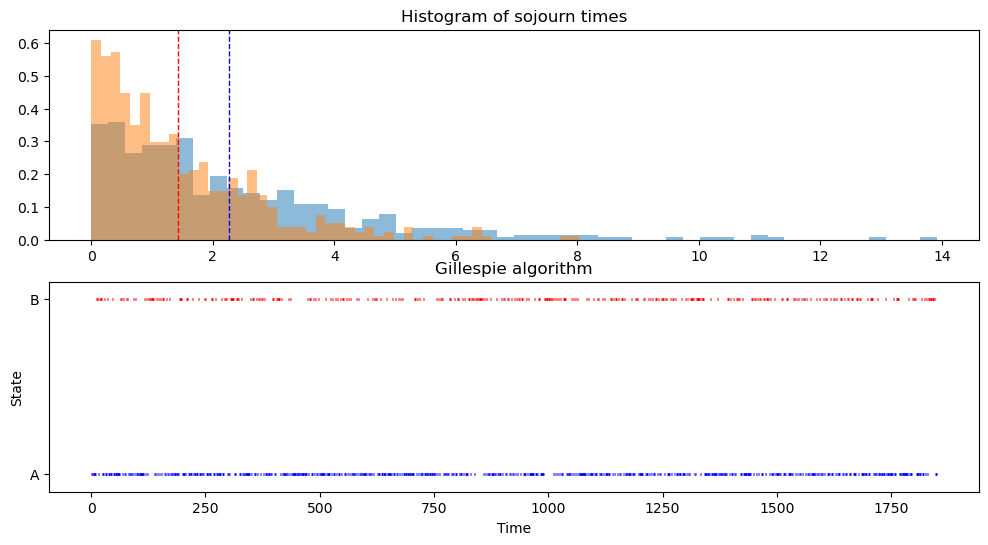

In [121]:
# Histogram of sojourn time spent in state A and B
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
sojourn_times_in_A = out[out["state"] == "A"]["sojourn_time"]
mean_sojourn_time_in_A = np.mean(sojourn_times_in_A)
sojourn_times_in_B = out[out["state"] == "B"]["sojourn_time"]
mean_sojourn_time_in_B = np.mean(sojourn_times_in_B)
axs[0].hist(sojourn_times_in_A, bins=50, density=True, alpha=0.5, label='A')
axs[0].hist(sojourn_times_in_B, bins=50, density=True, alpha=0.5, label='B')
# Add a vertical line at the mean.
axs[0].axvline(mean_sojourn_time_in_A, color='b', linestyle='dashed', linewidth=1)
axs[0].axvline(mean_sojourn_time_in_B, color='r', linestyle='dashed', linewidth=1)
axs[0].set_title("Histogram of sojourn times")

# Plot with two levels, A and B, and an horizontal segment for each sojourn time
# Plot horizontal segments
t = 0 # Time
for i in range(len(out)):
    state = out.iloc[i]["state"]
    sojourn_time = out.iloc[i]["sojourn_time"]
    axs[1].hlines(state, t, t + sojourn_time, linewidth=2, color="b" if state == "A" else "r")
    t += sojourn_time

axs[1].set_ylim([-0.1, 1.1])
axs[1].set_yticks([0, 1])
axs[1].set_yticklabels(["A", "B"])
axs[1].set_xlabel("Time")
axs[1].set_ylabel("State")
axs[1].set_title("Gillespie algorithm")
plt.show()

In [122]:
# Sum of time spend in A divided by the total time, by filtering the dataframe by state and summing the sojourn times divided by the total time
print(out[out["state"] == "A"]["sojourn_time"].sum() / out["sojourn_time"].sum())
print(k_BA / (k_AB + k_BA))
print(out[out["state"] == "B"]["sojourn_time"].sum() / out["sojourn_time"].sum())
print(k_AB / (k_AB + k_BA))

0.6153690128090882
0.6086956521739131
0.3846309871909119
0.391304347826087


## Spiraling in Control: Sequential Clockwise/2-Reside Step



### 3 states model

![](SC_2RS_kinetic_scheme.jpg)

In [123]:
# Protomer-ATP/ADP dissociation constants
K_d_ATP = 1
K_d_ADP = 1

# ATP/ADP ratio concentrations
ATP_over_ADP = 10
ATP_over_ADP_equilibrium = 1

# Transition rates

# Effective ATP/ADP exchange rates
k_DT = 1
# Constraint from ATP-ADP exchange model
k_TD = k_DT * K_d_ATP / K_d_ADP / ATP_over_ADP

# Move up and down rates
k_up = 1 # Choosen to be the rate of reference for the unit of time
k_down = 0.1

# ATP/ADP hydrolysis/synthesis rates
k_h = 0.1
# Thermodynamic constraint from kinetic scheme
k_s = k_h * k_up * k_DT / (k_down * k_TD) * ATP_over_ADP_equilibrium / ATP_over_ADP

# Model
model = nx.DiGraph()
model.add_edges_from([
    ("TTT", "DTT", {'rate': k_h}), ("DTT", "TTT", {'rate': k_s}),
    ("DTT", "TTD", {'rate': k_up}), ("TTD", "DTT", {'rate': k_down}),
    ("TTD", "TTT", {'rate': k_DT}), ("TTT", "TTD", {'rate': k_TD})]
)

In [124]:
out = gillespie(model, "TTT")
positions = compute_positions(out, transition_up=("DTT", "TTD"), transition_down=("TTD", "DTT"))

In [125]:
# Analytical average solutions

# Probability weights
p_TTT = k_s * k_DT + k_s * k_down + k_up * k_DT
p_DTT = k_h * k_down + k_down * k_TD + k_h * k_DT
p_TTD = k_up * k_TD + k_s * k_TD + k_h * k_up
normalization_factor = p_TTT + p_DTT + p_TTD
p_TTT /= normalization_factor
p_DTT /= normalization_factor
p_TTD /= normalization_factor

# Average velocity
v = k_up * p_DTT - k_down * p_TTD

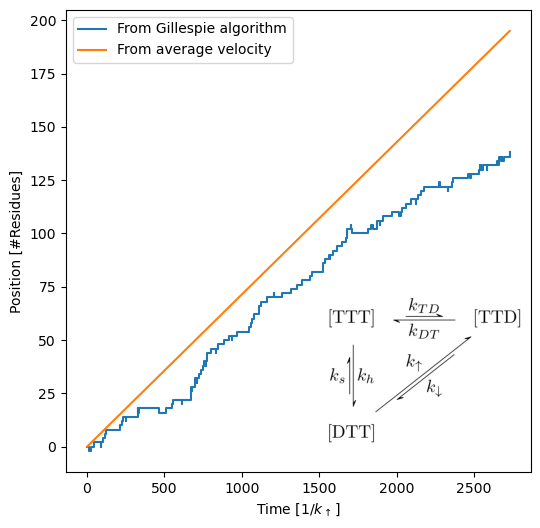

In [126]:
fig, ax = plot_position_evolution(positions, r"$1/k_\uparrow$", average_velocity=v, 
                        kinetic_scheme_path="SC_2RS_kinetic_scheme.jpg")
fig.savefig("SC_2RS_position_evolution.pdf", dpi=300, bbox_inches='tight')

### 4 states model

![](SC_2RS_4_states_kinetic_scheme.jpg)

In [127]:
# Protomer-ATP/ADP dissociation constants
# Main loop (1)
K_d_ATP_1 = 1
K_d_ADP_1 = 1
# Second loop (2)
K_d_ATP_2 = 1
K_d_ADP_2 = 1

# ATP/ADP ratio concentrations
ATP_over_ADP = 10
ATP_over_ADP_equilibrium = 1

# Transition rates

# Effective ATP/ADP exchange rates
# Main loop
k_DT_1 = 1
# Constraint from ATP-ADP exchange model
k_TD_1 = k_DT_1 * K_d_ATP_1 / K_d_ADP_1 / ATP_over_ADP
# Second loop
k_DT_2 = 0.1
# Constraint from ATP-ADP exchange model
k_TD_2 = k_DT_2 * K_d_ATP_2 / K_d_ADP_2 / ATP_over_ADP

# Move up and down rates
k_up = 1 # Choosen to be the rate of reference for the unit of time
k_down = 0.1

# ATP/ADP hydrolysis/synthesis rates
# Main loop
k_h_1 = 0.1
# Thermodynamic constraint from kinetic scheme
k_s_1 = k_h_1 * k_up * k_DT_1 / (k_down * k_TD_1) * ATP_over_ADP_equilibrium / ATP_over_ADP
# Second loop
k_h_2 = 0.1
# Thermodynamic constraint from kinetic scheme
k_s_2 = k_h_2 * k_up * k_DT_2 / (k_down * k_TD_2) * ATP_over_ADP_equilibrium / ATP_over_ADP

# Model
model = nx.DiGraph()
model.add_edges_from([
    ("TTT", "DTT", {'rate': k_h_1}), ("DTT", "TTT", {'rate': k_s_1}),
    ("DTT", "TTD", {'rate': k_up}), ("TTD", "DTT", {'rate': k_down}),
    ("TTD", "TTT", {'rate': k_DT_1}), ("TTT", "TTD", {'rate': k_TD_1}),
    ("TTD", "DTD", {'rate': k_h_2}), ("DTD", "TTD", {'rate': k_s_2}),
    ("DTD", "DTT", {'rate': k_DT_2}), ("DTT", "DTD", {'rate': k_TD_2})]
)

In [128]:
out = gillespie(model, "TTT")
positions = compute_positions(out, transition_up=("DTT", "TTD"), transition_down=("TTD", "DTT"))

In [129]:
# Analytical average solutions

# Probability weights
p_TTT = (k_s_1 * k_DT_1 * (k_DT_2 + k_s_2)
         + k_s_1 * (k_DT_2 * k_down + k_s_2 * k_down + k_DT_2 * k_h_2)
         + k_DT_1 * (k_up * k_s_2 + k_up * k_DT_2 + k_DT_2 * k_s_2))
p_DTT = (k_DT_2 * k_down * k_h_1
         + k_DT_2 * k_down * k_TD_1
         + k_down * k_h_1 * k_s_2
         + k_DT_2 * k_h_1 * (k_h_2 + k_DT_1)
         + k_DT_2 * k_h_2 * k_TD_1
         + k_down * k_s_2 * k_TD_1
         + k_h_1 * k_s_2 * k_DT_1)
p_DTD = (k_h_2 * k_TD_2 * (k_TD_1 + k_h_1)
         + k_h_2 * (k_TD_1 * k_up + k_h_1 * k_up + k_TD_1 * k_s_1)
         + k_TD_2 * (k_down * k_h_1 + k_down * k_TD_1 + k_DT_1 * k_h_1))
p_TTD = (k_TD_1 * k_up * k_s_2
         + k_TD_1 * k_up * k_DT_2
         + k_up * k_s_2 * k_h_1
         + k_TD_1 * k_s_2 * (k_s_1 + k_TD_2)
         + k_TD_1 * k_s_1 * k_DT_2
         + k_up * k_h_1 * k_DT_2
         + k_s_2 * k_h_1 * k_TD_2)
normalization_factor = p_TTT + p_DTT + p_DTD + p_TTD
p_TTT /= normalization_factor
p_DTT /= normalization_factor
p_DTD /= normalization_factor
p_TTD /= normalization_factor

# Average velocity
v = k_up * p_DTT - k_down * p_TTD

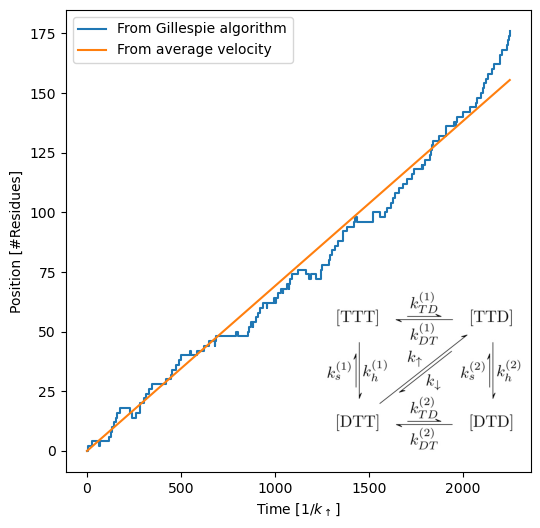

In [130]:
fig, ax = plot_position_evolution(positions, r"$1/k_\uparrow$", average_velocity=v, 
                        kinetic_scheme_path="SC_2RS_4_states_kinetic_scheme.jpg")
fig.savefig("SC_2RS_4_states_position_evolution.pdf", dpi=300, bbox_inches='tight')

## Disc-Spiral model

![](Disc_spiral_kinetic_scheme.jpg)

In [131]:
# Protomer-ATP/ADP dissociation constants
K_d_ATP = 1
K_d_ADP = 1

# ATP/ADP ratio concentrations
ATP_over_ADP = 10
ATP_over_ADP_equilibrium = 1

# Transition rates

# Effective ATP/ADP exchange rates
k_DT = 1
# Constraint from ATP-ADP exchange model
k_TD = k_DT * K_d_ATP / K_d_ADP / ATP_over_ADP

# ATP/ADP hydrolysis/synthesis rates
k_bar_h = 0.1
k_s = 0.1

# Spiral-disc transitions in ATP mode
k_spiral_to_disc_up = 1
k_disc_to_spiral_down = 1

# Disc-spiral transitions in ADP mode
k_disc_to_spiral_up = 1 # Choosen to be the rate of reference for the unit of time
# Thermodynamic constraint from kinetic scheme
k_spiral_to_disc_down = (k_bar_h * k_disc_to_spiral_up * k_DT * k_spiral_to_disc_up
                         / (k_s * k_TD * k_disc_to_spiral_down)
                         * ATP_over_ADP_equilibrium / ATP_over_ADP)

# Model
model = nx.DiGraph()
model.add_edges_from([
    ("━━", "┉┉", {'rate': k_bar_h}), ("┉┉", "━━", {'rate': k_s}),
    ("┉┉", "┋", {'rate': k_disc_to_spiral_up}), ("┋", "┉┉", {'rate': k_spiral_to_disc_down}),
    ("┋", "┃", {'rate': k_DT}), ("┃", "┋", {'rate': k_TD}),
    ("┃", "━━", {'rate': k_spiral_to_disc_up}), ("━━", "┃", {'rate': k_disc_to_spiral_down})]
)

In [132]:
out = gillespie(model, "━━")
positions = compute_positions(out, transition_up=("┉┉", "┋"), transition_down=("┋", "┉┉"))

In [133]:
# Analytical average solutions

# Probability weights
p_disc_ATP = (k_s * k_spiral_to_disc_down * k_spiral_to_disc_up
              + k_s * k_DT * k_spiral_to_disc_up
              + k_s * k_spiral_to_disc_down * k_TD
              + k_disc_to_spiral_up * k_DT * k_spiral_to_disc_up)
p_disc_ADP = (k_bar_h * k_spiral_to_disc_down * k_TD
              + k_bar_h * k_spiral_to_disc_down * k_spiral_to_disc_up
              + k_spiral_to_disc_down * k_TD * k_disc_to_spiral_down
              + k_bar_h * k_DT * k_spiral_to_disc_up)
p_spiral_ADP = (k_disc_to_spiral_up * k_TD * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_TD
                + k_s * k_TD * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_spiral_to_disc_up)
p_spiral_ATP = (k_s * k_DT * k_disc_to_spiral_down
                + k_disc_to_spiral_up * k_DT * k_disc_to_spiral_down
                + k_s * k_spiral_to_disc_down * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_DT)
normalization_factor = p_disc_ATP + p_disc_ADP + p_spiral_ADP + p_spiral_ATP
p_disc_ATP /= normalization_factor
p_disc_ADP /= normalization_factor
p_spiral_ADP /= normalization_factor
p_spiral_ATP /= normalization_factor

# Average velocity
v = k_disc_to_spiral_up * p_disc_ADP - k_spiral_to_disc_down * p_spiral_ADP

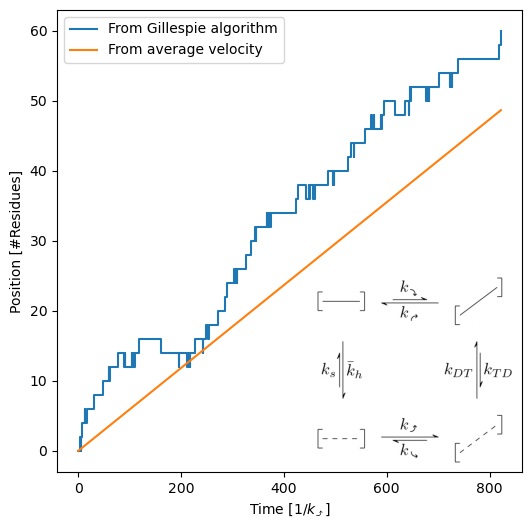

In [134]:
fig, ax = plot_position_evolution(positions, r"$1/k_⤴$", average_velocity=v, 
                        kinetic_scheme_path="Disc_spiral_kinetic_scheme.jpg")
fig.savefig("Disc_spiral_position_evolution.pdf", dpi=300, bbox_inches='tight')